In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

* Подключаем Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Указываем путь к папке с кодом: 

In [ ]:
repo_folder = '/content/drive/MyDrive/github/'

* Устанавливаем зависимости

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* Подключаем WandB

In [ ]:
import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key.strip())

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

* Подключаем утилиты для этого ноутбука

In [ ]:
import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/a_Text_Detection/'
sys.path.append(base_folder)

In [ ]:
from utils import set_seed

set_seed(17)

Seed is set to  17


# 1. Данные

## 1.1. Загрузка данных

In [ ]:
%%time

from utils import HierTextAdapter

# HierText
train_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/train.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/train',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

train_adapters = [
    train_hiertext_adapter,
]
_ = [a[0] for a in train_adapters]

# HierText
val_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/validation.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/validation',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

val_adapters = [
    val_hiertext_adapter,
]
_ = [a[0] for a in val_adapters]

CPU times: user 37.1 s, sys: 8.15 s, total: 45.2 s
Wall time: 44.9 s


### 1.1.1. Визуализация

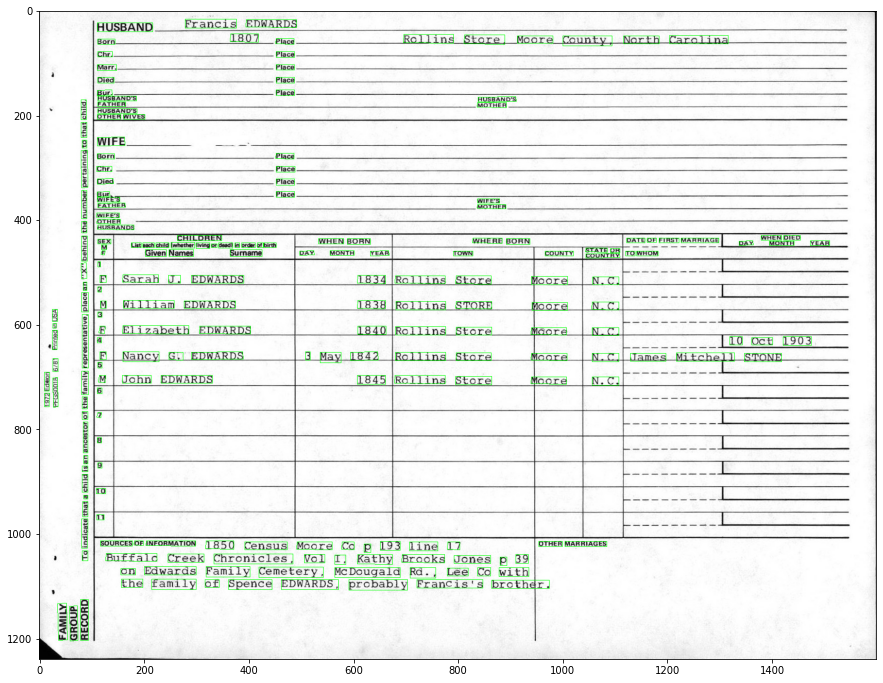

In [ ]:
import matplotlib.pyplot as plt
from utils import DrawMore

item = train_hiertext_adapter[6]

plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(item.img, item.word_polygons, thickness=1))
plt.show()

### 1.1.2. Подсчет статистик

##### Код

In [ ]:
import cv2
import numpy as np 
all_bboxes = [bbox 
              for word_polygons, _ in bboxes_and_shapes_by_image 
              for bbox in word_polygons]

widths = []
heights = []
for bbox in all_bboxes:
    (_, _), (w, h), _ = cv2.minAreaRect(np.array(bbox))
    widths.append(w)
    heights.append(h)

In [ ]:
from typing import List, Tuple
import numpy as np
from tqdm.notebook import tqdm

def make_heatmap(
    bboxes_and_shapes_by_image: List[Tuple[List[np.ndarray], List[Tuple]]],
    adapter: HierTextAdapter, 
    res_w: int = 500, 
    res_h: int = 500) -> np.ndarray:


    results = np.zeros((500,500))
    reshape_matrix = [np.round(np.array(i)/np.array([_[1], _[0]])*500) for box, _  in bboxes_and_shapes_by_image for i in box]
    for i in tqdm(reshape_matrix):
      for g in i:
        help_matrix=np.zeros((500,500))
        help_matrix = cv2.fillPoly(help_matrix, [np.int32(i)] ,1)
      results += help_matrix


    results /= len(reshape_matrix)
    return results

    

  0%|          | 0/210345 [00:00<?, ?it/s]

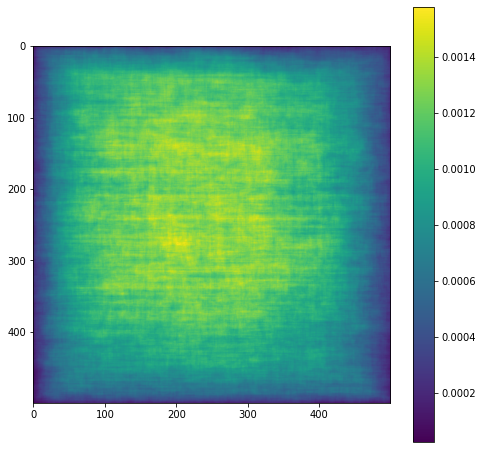

In [ ]:
heatmap = make_heatmap(bboxes_and_shapes_by_image, 500, 500)

plt.figure(figsize=(8, 8))
plt.imshow(heatmap)
plt.colorbar()
plt.show()

## 1.2. Аугментации и подготовка DataLoader

### 1.2.1. Аугментации

###### Код

In [ ]:

train_transform = A.Compose([
    size_transform,
    A.OneOf([
    A.RandomBrightnessContrast(p=1),
    A.RGBShift(50,50,50, p=1),
    A.ChannelShuffle(p=1),
    ], p=0.2),
    A.InvertImg(p=0.1),
    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
    A.OneOf([
     A.GaussNoise(var_limit=(10.0, 50.0)),
    A.ISONoise(color_shift=(0.91, 0.75))
    ], p=0.4),
    A.OneOf([
    A.RandomRotate90(p=0.7),
    A.ShiftScaleRotate(shift_limit=0.2625, scale_limit=0.3, rotate_limit=45, interpolation=1),
    A.Perspective(scale=(0.25, 0.21), keep_size=True)
    ], p=0.3),
    A.ToGray(p=0.3)
])

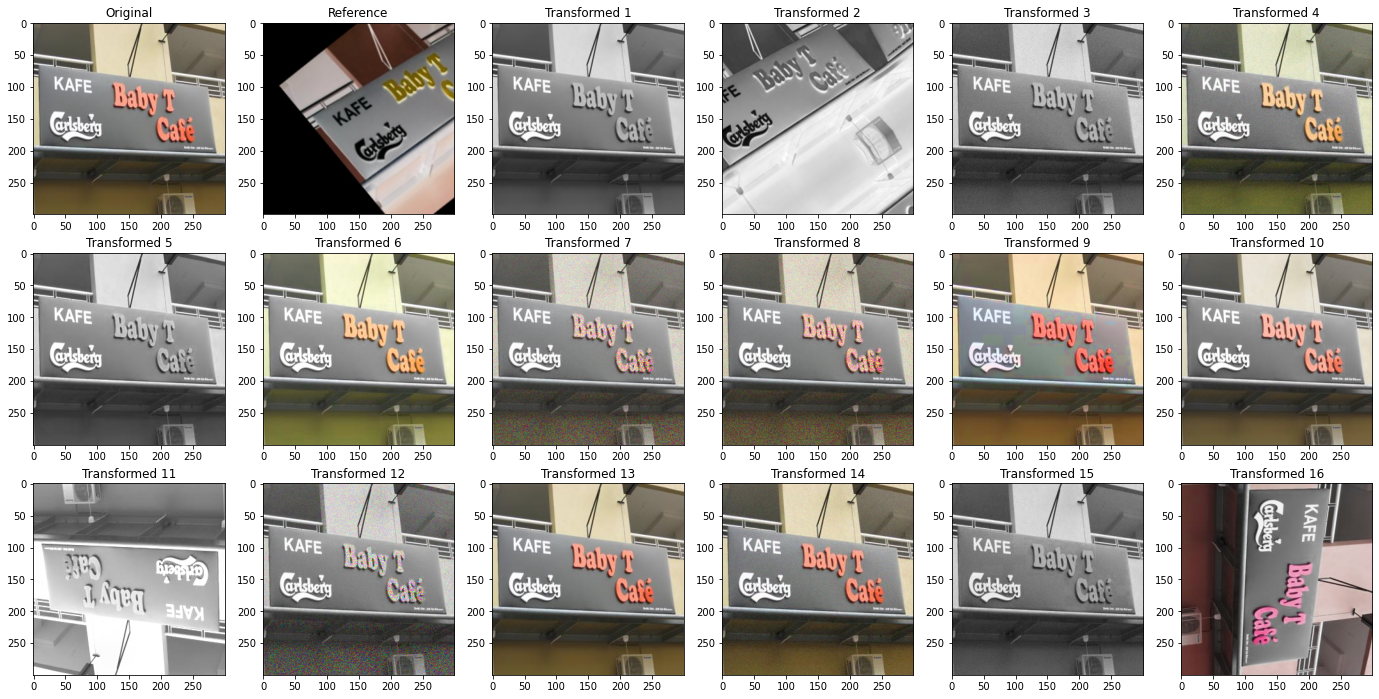

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(image_auged_ref)
axs[0, 1].set_title('Reference')
for i in range(2, 18):
  col = i % NCOLS
  row = i // NCOLS
  # здесь используем train_transform[1:] для того, чтобы все картинки остались одного размера
  image_transformed = A.Compose(train_transform[1:])(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i-1}')
plt.show()

In [ ]:
from albumentations.pytorch import ToTensorV2

val_transform = size_transform
test_transform = size_transform

post_transform = A.Compose([
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

### 1.2.2. Визуализация аугментаций

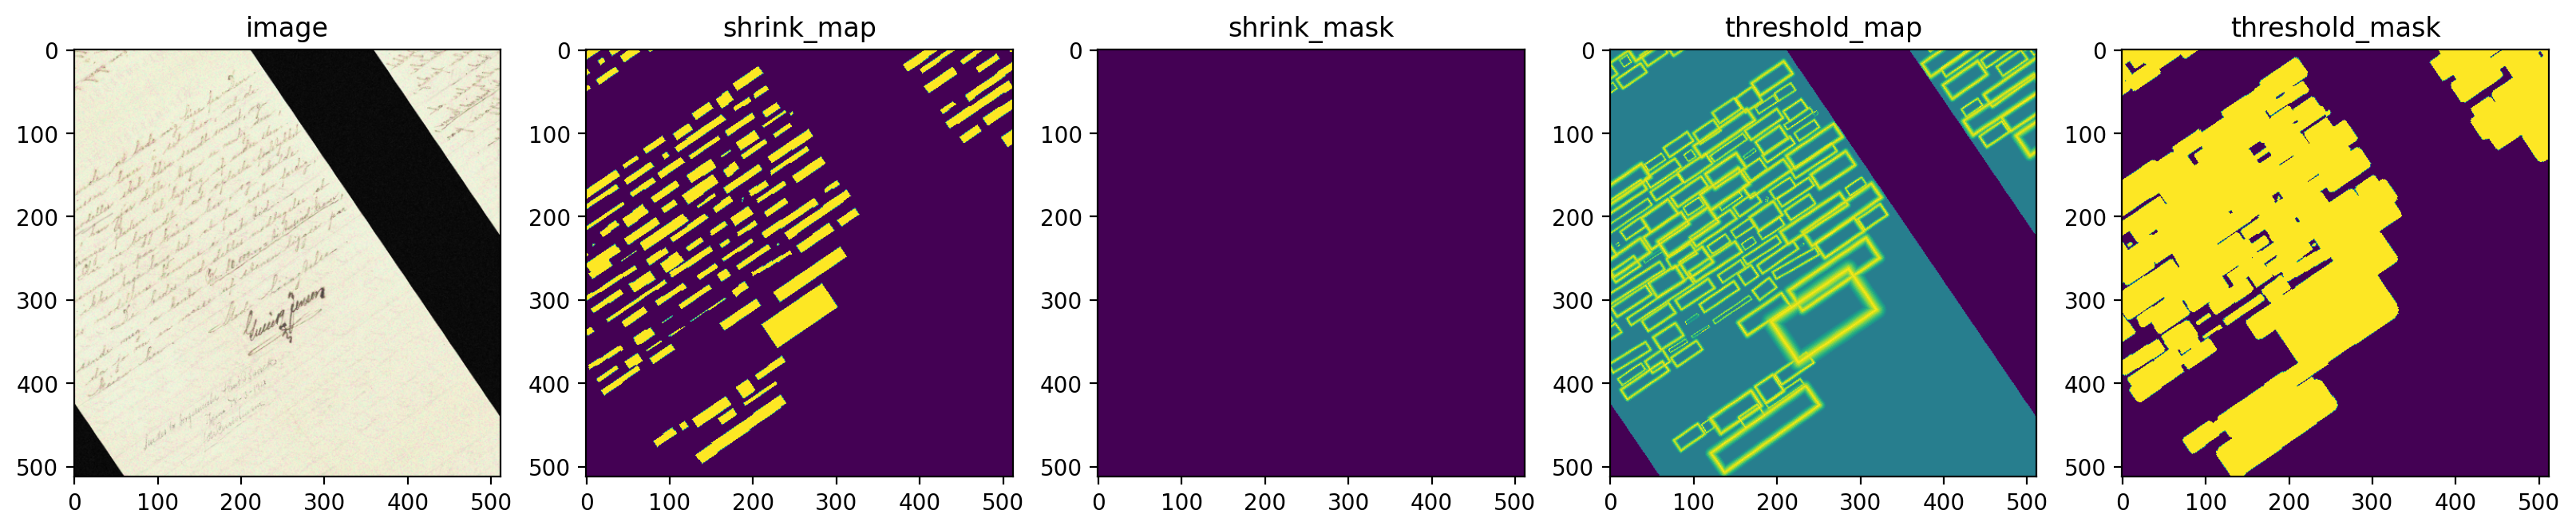

In [ ]:
from utils import DBDataset

dataset = DBDataset(train_adapters, train_transform, post_transform)
idx = np.random.choice(len(dataset))
raw_image, image, shrink_map, shrink_mask, threshold_map, threshold_mask, gt_polygon = dataset[idx]

fig, ax = plt.subplots(1, 5, figsize=(20, 20), dpi=200)

ax = ax.ravel()

ax[0].set_title('image')
ax[0].imshow(raw_image)

ax[1].set_title('shrink_map')
ax[1].imshow(shrink_map)

ax[2].set_title('shrink_mask')
ax[2].imshow(shrink_mask)

ax[3].set_title('threshold_map')
ax[3].imshow(threshold_map)

ax[4].set_title('threshold_mask')
ax[4].imshow(threshold_mask)


plt.show()

### 1.2.3. Преобразование сегментации в bounding box-ы

In [ ]:
from utils import Postprocessor

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.7,
    min_area=1,
    max_number=1000
)

In [ ]:
idx = np.random.choice(len(dataset))
raw_image, image, shrink_map, shrink_mask, threshold_map, threshold_mask, gt_polygon = dataset[idx]
h, w, c = raw_image.shape
shrink_map= np.expand_dims(np.expand_dims(shrink_map, axis=0), axis=0)
map_polygons, _ = postprocessor(w, h, shrink_map, return_polygon=False)

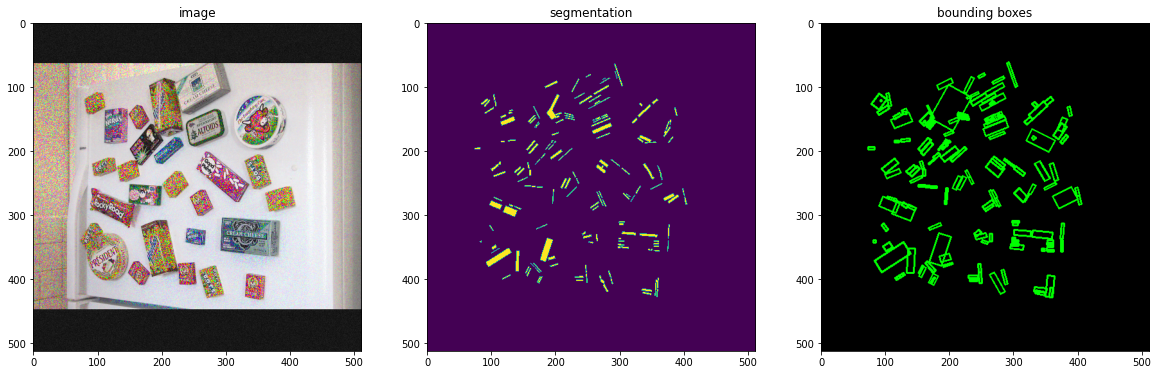

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax = ax.ravel()

ax[0].set_title('image')
ax[0].imshow(raw_image)

ax[1].set_title('segmentation')
ax[1].imshow(shrink_map[0][0])

ax[2].set_title('bounding boxes')
ax[2].imshow(DrawMore.draw_contours(np.zeros_like(raw_image), map_polygons[0], thickness=2))

plt.show()

### 1.2.4. Подготовка DataLoader-ов

In [ ]:
import os

from torch.utils.data import DataLoader

from utils import collate, worker_init_fn

num_workers = os.cpu_count()  # количество ядер CPU, которые мы выделяем даталоадеру
batch_size = 16  # количество изображений в одном батче

train_ds = DBDataset(
    adapters=train_adapters,
    transforms=train_transform,
    post_transforms=post_transform,
    size=1000  # на каждой эпохе для обучения будет 1000 изображений

)
val_ds = DBDataset(
    adapters=val_adapters,
    transforms=val_transform,
    post_transforms=post_transform,
    size=400  # на каждой эпохе для валидации будет 400 изображений
)

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=True,
    drop_last=False
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

# 2. Модель

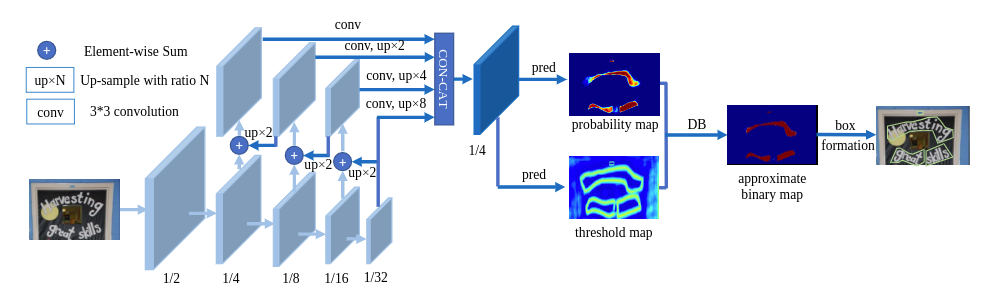

### Задача 4. Step function для модели DB

In [ ]:
import torch

def step_function(p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
    return torch.reciprocal(1+torch.exp(-k*(p-t)))

In [ ]:
prob_map = cv2.imread(base_folder + 'examples/prob_map.png', cv2.IMREAD_GRAYSCALE)
threshold_map = cv2.imread(base_folder + 'examples/threshold_map.png', cv2.IMREAD_GRAYSCALE)
true_after_step_function = cv2.imread(base_folder + 'examples/step_function.png', cv2.IMREAD_GRAYSCALE)

after_step_function = step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k=50).numpy() * 255
assert np.allclose(true_after_step_function, after_step_function.astype(int)), msg

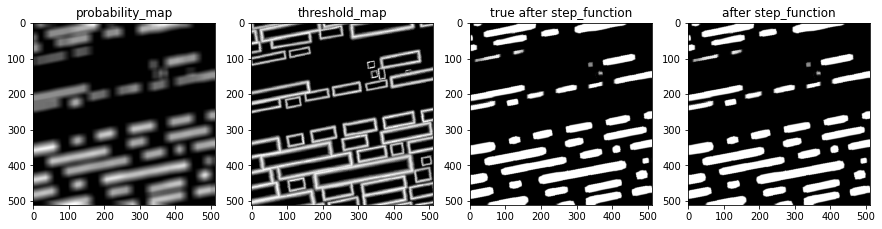

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.imshow(prob_map, cmap='gray')
ax1.set_title('probability_map')

ax2.imshow(threshold_map, cmap='gray')
ax2.set_title('threshold_map')

ax3.imshow(true_after_step_function, cmap='gray')
ax3.set_title('true after step_function')

ax4.imshow(after_step_function, cmap='gray')
ax4.set_title('after step_function')

plt.show()

In [ ]:
from ipywidgets import interact, IntSlider

def wrapper(k=50):
  plt.figure(figsize=(6, 6))
  plt.imshow(step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k), cmap='gray')
    
interact(wrapper, k=IntSlider(min=1, max=50, step=1, value=10));

interactive(children=(IntSlider(value=10, description='k', max=50, min=1), Output()), _dom_classes=('widget-in…

### Задача 5: Реализация `DBHead`

##### Код

In [ ]:

from torch import nn

class DBHead(nn.Module):
    def __init__(self, in_channels: int, k: int = 50):
        """
        Класс головы модели DB из статьи https://arxiv.org/abs/1911.08947.

        Args:
            in_channels: входное количество каналов
            k: значение параметра k в step function (см. статью)
        """
        super().__init__()
        self.k = k
        self.binarize = self._init(in_channels)
        self.thresh = self._init(in_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shrink_maps = self.binarize(x)
        threshold_maps = self.thresh(x)
        binary_maps = self.step_function(shrink_maps, threshold_maps, self.k)
        y = torch.cat((shrink_maps, threshold_maps, binary_maps), dim=1)
        return y

    def _init(self, inner_channels: int, bias: bool = True) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels//4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(),
            nn.ConvTranspose2d(inner_channels//4, inner_channels//4, kernel_size=(2, 2), stride=(2, 2), bias=False),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(),
            nn.ConvTranspose2d(inner_channels//4, 1, kernel_size=(2, 2), stride=(2, 2)),
            nn.Sigmoid()

        )
        
    
    def step_function(self, p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
        return torch.reciprocal(1+torch.exp(-self.k*(p-t)))

###  6. Сборка модели

#### Код

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F


class DB(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = smp.FPN(encoder_name='timm-regnetx_016', upsampling=4)  # FPN из smp
        self.body.segmentation_head = torch.nn.Identity()
        self.head = DBHead(in_channels=128, k=50)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, H, W = x.size()
        x = self.body(x)
        x = self.head(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

# 3. Метрики и функция потерь

###  7. Метрики

#### Код

In [ ]:

from utils import BaseEvaluator
from shapely.geometry import Polygon

class Evaluator(BaseEvaluator):
    @staticmethod
    def get_iou(p1: Polygon, p2: Polygon) -> float:
        return p1.intersection(p2).area/p1.union(p2).area

# 4. Обучение

## 4.1. Pytorch Lightning Module

In [ ]:
import pytorch_lightning as pl

from typing import Any, Tuple, List
from utils import DBLoss
from utils import log_losses_and_metrics, log_images

from torch import optim

class DBRunner(pl.LightningModule):
    def __init__(self):
        """
        Основной класс для обучения модели DB.
        """
        super(DBRunner, self).__init__()

        self.model = DB()

        self.evaluator = Evaluator()
        self.postprocessor = Postprocessor(
            unclip_ratio=1.5,
            binarization_threshold=0.3,
            confidence_threshold=0.7,
            min_area=1,
            max_number=1000
        )

        self.loss = DBLoss(
            alpha=1,
            beta=10,
            ohem_ratio=3,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага обучения.

        Args:
            batch: батч
            batch_idx: индекс батча

        Returns:
            лосс
        """
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        log_losses_and_metrics(self.log, losses, metrics=None, current_batch_size=current_batch_size, mode='train')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            h, w, c = raw_images[0].shape

            shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])
            pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

            train_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
            train_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
            metrics_after_step = self.evaluator(train_gt_polygons, train_polygons_after_step)

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                train_gt_polygons,
                train_polygons_after_step,
                metrics_after_step,
                mode='train',
                log_max=4
            )

        return losses["loss"]

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага валидации.

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        h, w, c = raw_images[0].shape

        shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
        pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

        val_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
        val_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
        metrics_after_step = self.evaluator(val_gt_polygons, val_polygons_after_step)

        log_losses_and_metrics(self.log, losses, metrics_after_step, current_batch_size=current_batch_size, mode='val')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                val_gt_polygons,
                val_polygons_after_step,
                metrics_after_step,
                mode='val'
            )

    def test_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага тестирования (аналогичный шагу валидации).

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        self.validation_step(batch, batch_idx)

    def configure_optimizers(self) -> Tuple[List[Any], List[Any]]:
        """
        Метод для настройки оптимизаторов обучения и планировщиков для learning rate (LR).

        Returns:
            список оптимизаторов; список планировщиков LR
        """
        optimizer = optim.AdamW(
            self.parameters(), lr=5.0e-4, betas=(0.9, 0.999), weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer=optimizer,
            base_lr=0.0001,
            max_lr=0.0075,
            step_size_up=235,
            step_size_down=235 * 4,
            mode="triangular",
            cycle_momentum=False,
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_losses/val_loss_epoch",
        }
        print(lr_scheduler)
        print(optimizer)
        return [optimizer], [scheduler]

## 4.2. Настройка логирования

### 4.2.1. Сохранение весов

In [ ]:
from datetime import datetime
import os

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

model = DBRunner()

version = datetime.now().strftime("%Y%m%dT%H%M%S")

lr_logger = LearningRateMonitor()

logs_dir = "/content/drive/MyDrive/tmp/logs"
project_name = "sber-td-course"
exp_name = "test"

cfg_save_dir = os.path.join(logs_dir, project_name, exp_name)
checkpoint_callback = ModelCheckpoint(
    dirpath=cfg_save_dir,
    mode="min",
    monitor="val_losses/val_loss_epoch",
    save_top_k=1,
    verbose=True,
    save_last=True
)

### 4.2.2. Логирование метрик

In [ ]:
os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

In [ ]:
wandb.finish()

## 4.3. Запуск обучения

In [ ]:
trainer = Trainer(
    callbacks=[checkpoint_callback, lr_logger],
    logger=logger,
    gpus=[0],
    min_epochs=1,
    max_epochs=30,
    gradient_clip_val=0.5,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | DB     | 10.4 M
1 | loss  | DBLoss | 0     
---------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params
41.535    Total estimated model params size (MB)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)


Sanity Checking: 0it [00:00, ?it/s]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/base_evaluator.py:66: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(gt_polygons)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 63: 'val_losses/val_loss_epoch' reached 2.90468 (best 2.90468), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=0-step=63.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 126: 'val_losses/val_loss_epoch' reached 2.76208 (best 2.76208), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=1-step=126.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 189: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 252: 'val_losses/val_loss_epoch' reached 1.82863 (best 1.82863), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=3-step=252.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 315: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 378: 'val_losses/val_loss_epoch' reached 1.72016 (best 1.72016), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=5-step=378.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 441: 'val_losses/val_loss_epoch' reached 1.65997 (best 1.65997), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=6-step=441.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 504: 'val_losses/val_loss_epoch' reached 1.64091 (best 1.64091), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=7-step=504.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 567: 'val_losses/val_loss_epoch' reached 1.60354 (best 1.60354), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=8-step=567.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 630: 'val_losses/val_loss_epoch' reached 1.59154 (best 1.59154), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=9-step=630.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 693: 'val_losses/val_loss_epoch' reached 1.57173 (best 1.57173), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=10-step=693.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 756: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 819: 'val_losses/val_loss_epoch' reached 1.52362 (best 1.52362), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=12-step=819.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 882: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 945: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1008: 'val_losses/val_loss_epoch' reached 1.47821 (best 1.47821), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=15-step=1008.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 1071: 'val_losses/val_loss_epoch' reached 1.45629 (best 1.45629), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=16-step=1071.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1134: 'val_losses/val_loss_epoch' reached 1.44214 (best 1.44214), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=17-step=1134.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1197: 'val_losses/val_loss_epoch' reached 1.44077 (best 1.44077), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=18-step=1197.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1260: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 1323: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1386: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1449: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1512: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1575: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1638: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1701: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1764: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1827: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1890: 'val_losses/val_loss_epoch' reached 1.42753 (best 1.42753), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=29-step=1890.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## 4.4. Тестирование

In [ ]:
test_adapters = [
    ('hiertext', val_hiertext_adapter),
]

num_workers = os.cpu_count()
batch_size = 16

test_transform = size_transform

test_dls = []

for (adapter_name, adapter) in test_adapters:
    test_dataset = DBDataset(
        adapters=[adapter], 
        transforms=test_transform,
        post_transforms=post_transform
    )
    test_dl = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate, 
        worker_init_fn=worker_init_fn, 
        pin_memory=True, 
        shuffle=False, 
        drop_last=False
    )
    test_dls.append((adapter_name, test_dl))

In [ ]:
model = DBRunner.load_from_checkpoint('/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=29-step=1890.ckpt')

for (dl_name, dl) in test_dls:
    print(dl_name)
    trainer.test(model=model, dataloaders=dl)

hiertext


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

# 5. Экспорт модели

###  8. Экспорт модели

#### Код

In [ ]:
from typing import Type

def jit_save(checkpoint_path: str, jit_path: str, runner_class: Type[DBRunner]) -> None:
    model = DBRunner.load_from_checkpoint(checkpoint_path).model.eval()
    x = torch.rand(1, 3, 512, 512)
    scripted_model = torch.jit.trace(model, x)
    saved_model = torch.jit.save(scripted_model, jit_path)

# 6. Inference

###  8. Inference

#### Код

In [ ]:
from typing import Union

from albumentations import BasicTransform, Compose, OneOf

size = 2048


def inference(
    model: nn.Module, 
    image: np.ndarray, 
    preprocessor: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[np.ndarray]:
    h, w, c = image.shape
    # подготовка изображения (c помощью preprocessor)
    image = preprocessor(image= image)['image'].unsqueeze_(0)
    # предсказание модели (с помощью model)
    preds = model(image)
    # постпроцессинг предсказаний (с помощью postprocessor)
    pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])
    map_polygons, _ = postprocessor(w, h, pred_bin_maps, return_polygon=False)
  
    map_polygons = [np.array(i) for i in map_polygons[0]]
    return map_polygons

    
preprocessor =  A.Compose([
    A.LongestMaxSize(
        max_size=size,
        p=1.0,
    ),
    A.PadIfNeeded(
        min_height=size,
        min_width=size,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=None,
        always_apply=False,
        p=1.0,
    ),
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

postprocessor = postprocessor

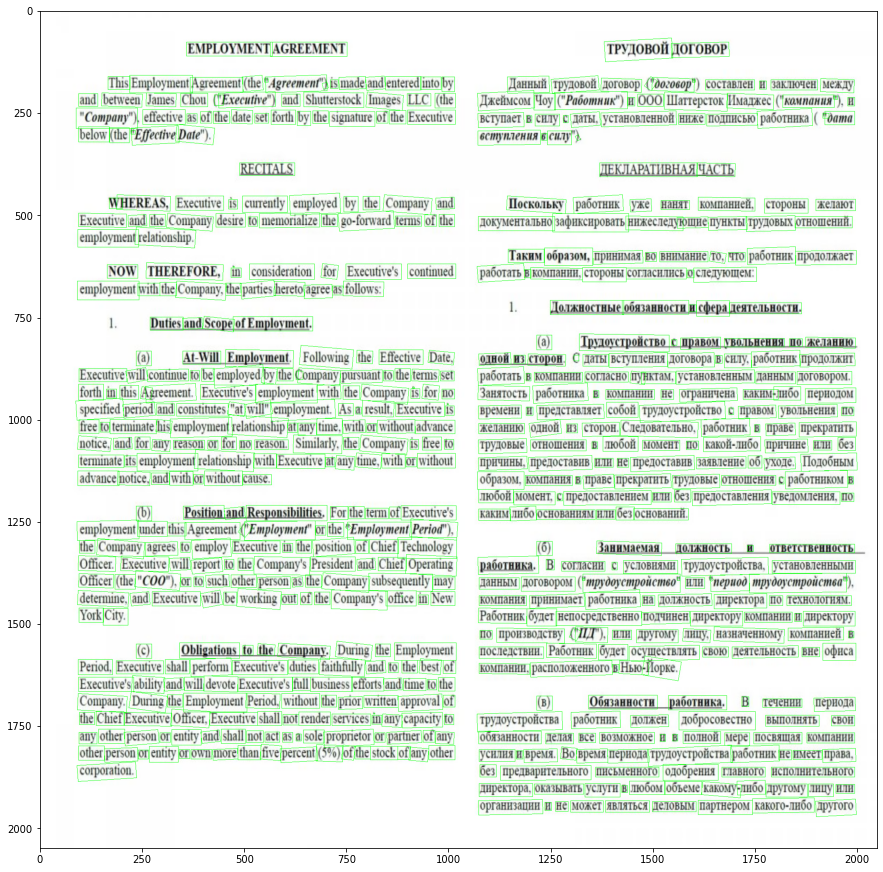

In [ ]:
# визуализация предсказаний
plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(image, bboxes, thickness=1))
plt.show()